In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define transformações para pré-processamento das imagens
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

In [3]:
# Carrega o dataset a partir do diretório 'images'
dataset = datasets.ImageFolder('./classes/', transform=transform)

In [4]:
# Divida o dataset em conjuntos de treinamento e teste
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [5]:
# Defina os dataloaders para carregar os dados
batch_size = 112
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Definir modelo CAE
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Codificação
        x = self.encoder(x)
        
        # Decodificação
        x = self.decoder(x)
        
        return x

In [7]:
# Carregando o modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder = CAE()
autoencoder.load_state_dict(torch.load('cae.pth'))
# autoencoder = autoencoder.to(device)

<All keys matched successfully>

In [8]:
# Extrai recursos das imagens usando a rede não supervisionada
def get_features(dataloader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in dataloader:
            batch_features = model.encoder(images)
            batch_features = batch_features.reshape(batch_features.size(0), -1)
            features.append(batch_features)
            labels.append(batch_labels)
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return features, labels

In [9]:
# Extrai recursos das imagens usando a rede não supervisionada
train_features, train_labels = get_features(train_loader, autoencoder)
test_features, test_labels = get_features(test_loader, autoencoder)

In [10]:
# Cria a rede de classificação supervisionada e a treina usando os recursos extraídos

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [11]:
model = CNN()
model = model.to(device)

In [13]:
# Definir função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
num_epochs = 300
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    # Avalia a acurácia no conjunto de dados de teste
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Epoch [{}/{}], Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch+1, num_epochs, loss.item(), 100*correct/total))

    # Salvando o modelo
torch.save(model.state_dict(), 'cnn.pth')

Epoch [1/1], Loss: 0.2896, Test Accuracy: 78.10%


Classe predita: sky_with_meteor


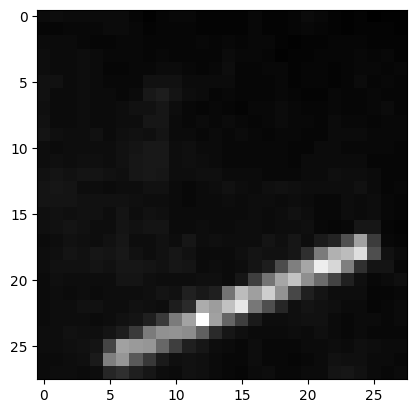

In [27]:
# Faça a inferência em uma imagem de exemplo
import os
from PIL import Image

# Especifica o caminho para a pasta com os arquivos .pg
folder_path = './classes/sky_with_meteor/'

# Obtém uma lista com o nome de todos os arquivos na pasta
file_list = os.listdir(folder_path)

# Itera sobre cada arquivo na lista
for file_name in file_list:
    # Verifica se o arquivo tem a extensão .pg
    if file_name.endswith('.png'):
        # Abre o arquivo com a biblioteca PIL
        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        
        image = transform(image).to(device)

        # Faça a inferência na rede neural na imagem de exemplo
        model.eval()
        with torch.no_grad():
            output = model(image.unsqueeze(0))
            _, predicted = torch.max(output, 1)

        # Exiba a classe predita pela rede neural
        print('Classe predita: %s' % dataset.classes[predicted])
        plt.imshow(image.cpu().detach().squeeze(), cmap='gray')
        plt.show()

    break